In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas
import pointprocesses as ppr

In [3]:
import torch

# Données synthétiques

In [4]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [5]:
import itertools
mu = 1.0
tmax = 5.0
alpha = 0.25
beta  = 2.0

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 6.667


In [30]:
n_traj = 400
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

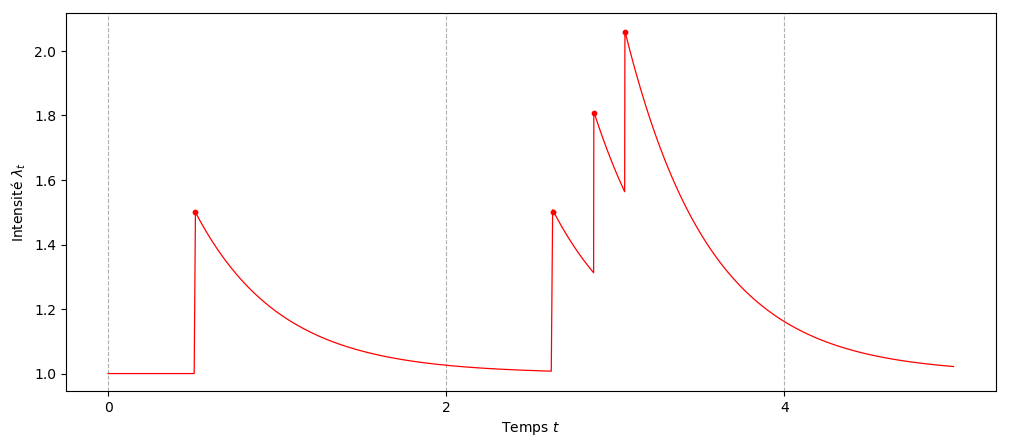

In [31]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [209]:
print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
data_array = np.stack([np.pad(s[:,0], ((0, input_size - s.shape[0])), 'constant') for s in sample_trajectories])
data_tensor = torch.from_numpy(data_array).to(torch.float32)

Number of samples: 		400
Input size max. traj. length: 	17


In [203]:
data_tensor.shape

torch.Size([400, 17])

The first dimension is for time, the second for the sample.

## Neural net

In [195]:
import torch
import torch.nn as nn
from torch import optim

In [196]:
device = torch.device("cpu")
print(device)

cpu


In [197]:
torch.manual_seed(1)

$$
    \lambda_k(t) = f_k(\mathbf w_k^\intercal\mathbf h(t))
$$

$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i]
$$

In [232]:
from model import NeuralCTLSTM
import tqdm

In [233]:
# We use mini-batches to train on our data
BATCH_SIZE = 40
print("Batch size: %d" % BATCH_SIZE)
print("Training sample size: %d" % data_tensor.size(0))
print("Splitting into batches of %d" % BATCH_SIZE)
split_into_batches = data_tensor.split(BATCH_SIZE, dim=0)
num_of_batches = len(split_into_batches)
print("No. of batches: %d" % num_of_batches)

Batch size: 40
Training sample size: 400
Splitting into batches of 40
No. of batches: 10


In [234]:
hidden_size = 8
learn_rate = 0.0008

nhlstm = NeuralCTLSTM(hidden_size)
optimizer = optim.SGD(nhlstm.parameters(), lr=learn_rate)

Each training loop:
* reinitializes the hidden state weights
* zeroes the gradients
* computes the loss

In [ ]:
# batch_range = tqdm.trange(num_of_batches)
# batch_range = tqdm.trange(data_tensor.size(0))
train_size = 400
batch_range = tqdm.trange(train_size)
loss_hist = []
for i in batch_range:
    batch_range.set_description("Batch %d" % i)
    # sample's event times
    event_times = data_tensor[i]
    dt = event_times[1:] - event_times[:-1]
    ## Train on each batch
    # event_times = split_into_batches[i]
    # inter_t = event_times[:,:-1] - event_times[:,1:] # transform into inter-arrival times
    # batch_size = inter_t.size(0)
    output_hist = []
    hidden_hist = []
    cell_hist = []
    cell_target_hist = []
    decay_hist = []
    hidden, cti, cbar = nhlstm.init_hidden()
    nhlstm.zero_grad()
    for j in range(input_size - 1):
        # Loop over times
        # Feed the RNN each batch of interarrival times
        output, hidden, cti, cell_t, cbar, decay_t = nhlstm(dt[j], hidden, cti, cbar)
        output_hist.append(output)
        hidden_hist.append(hidden)
        cell_hist.append(cti)
        cell_target_hist.append(cbar)
        decay_hist.append(decay_t)
    output_hist = torch.stack(output_hist, dim=1)
    hidden_hist = torch.stack(hidden_hist, dim=1)
    cell_hist = torch.stack(cell_hist, dim=1)
    cell_target_hist = torch.stack(cell_target_hist, dim=1)
    decay_hist = torch.stack(decay_hist, dim=1)
    loss = nhlstm.likelihood(event_times, seq_lengths[i], cell_hist, cell_target_hist, output_hist, decay_hist, tmax)
    # Compute the gradients
    loss.backward()
    # Update the model parameters
    optimizer.step()
    loss_val = loss.item()
    batch_range.set_postfix(loss=loss_val)
    loss_hist.append(loss_val) # record the loss value





















  0%|          | 0/400 [00:00<?, ?it/s]



















Batch 0:   0%|          | 0/400 [00:00<?, ?it/s]



















Batch 0:   0%|          | 0/400 [00:00<?, ?it/s, loss=5.49]



















Batch 1:   0%|          | 0/400 [00:00<?, ?it/s, loss=5.49]



















Batch 1:   0%|          | 0/400 [00:00<?, ?it/s, loss=6.36]



















Batch 2:   0%|          | 0/400 [00:00<?, ?it/s, loss=6.36]



















Batch 2:   0%|          | 0/400 [00:00<?, ?it/s, loss=6.02]



















Batch 3:   0%|          | 0/400 [00:00<?, ?it/s, loss=6.02]



















Batch 3:   0%|          | 0/400 [00:00<?, ?it/s, loss=5.69]



















Batch 4:   0%|          | 0/400 [00:00<?, ?it/s, loss=5.69]



















Batch 4:   0%|          | 0/400 [00:00<?, ?it/s, loss=4.72]



















Batch 5:   0%|          | 0/400 [00:00<?, ?it/s, loss=4.72]



















Batch 5:   0%|          | 0/400 [00:00<?, ?it/s, loss=4.62]





> e:\documents\études\map511-p3a\notebooks\model.py(169)likelihood()
-> integral = torch.sum(inter_times*lam_samples)






















Batch 212:  53%|█████▎    | 212/400 [00:13<00:03, 57.81it/s, loss=-4.01]

(Pdb)  indices


tensor([ 0,  1,  2,  2,  3,  3,  4,  4,  6,  8,  8, 10, 11, 11, 15, 17])


(Pdb)  samples


tensor([0.1654, 1.1503, 1.3095, 1.3700, 1.9026, 1.9642, 2.2149, 2.3208, 2.4581,
        2.9267, 2.9841, 3.1857, 3.2219, 3.3379, 3.8929, 4.4308, 4.7814])


(Pdb)  event_times


tensor([0.5454, 1.1789, 1.5191, 1.9662, 2.3485, 2.4191, 2.6708, 2.9167, 3.1103,
        3.1588, 3.2015, 3.3506, 3.5982, 3.7218, 3.8074, 3.8974, 4.0486])


Text(0.5, 1.0, 'Loss = negative log-likelihood')

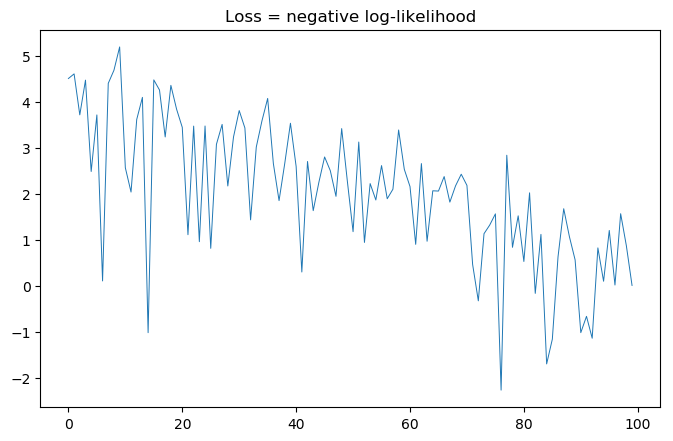

In [230]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
lineopts = {
    "linewidth": 0.7
}
ax.plot(range(100), loss_hist, **lineopts)
ax.set_title("Loss = negative log-likelihood")

In [60]:
grid = torch.from_numpy(np.linspace(0,1,11))

In [61]:
grid

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000], dtype=torch.float64)

In [70]:
tar, _ = torch.rand(11, dtype=torch.float64).sort(0)

In [71]:
tar

tensor([0.0029, 0.0441, 0.0862, 0.1899, 0.3177, 0.3932, 0.6351, 0.6634, 0.8085,
        0.9720, 0.9771], dtype=torch.float64)

In [85]:
for t in tar:
    print((t >= grid).sum())

tensor(1)
tensor(1)
tensor(1)
tensor(2)
tensor(4)
tensor(4)
tensor(7)
tensor(7)
tensor(9)
tensor(10)
tensor(10)


In [86]:
indices = torch.sum(tar[:,None] >= grid, dim=1)-1
indices

tensor([0, 0, 0, 1, 3, 3, 6, 6, 8, 9, 9])

In [87]:
grid[indices]

tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.3000, 0.3000, 0.6000, 0.6000, 0.8000,
        0.9000, 0.9000], dtype=torch.float64)

In [101]:
(grid[1:] - grid[:-1])[indices]

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000], dtype=torch.float64)